In [1]:
import pandas as pd
import pandas.io.sql as pd_sql
import sqlite3 as sql
import numpy as np
from pandas import Series, DataFrame
import math
import matplotlib.pyplot as plt
np.set_printoptions(precision=8)


#scrub sanitizes database inputs by only accepting alphanumerics, i.e. A-Z a-z 0-9
#this prevents sql injection
#as a result, table names should only contain alphanumerics, special symbols may get scrubbed away
def scrub(db_input):
    return ''.join( chr for chr in db_input if chr.isalnum() )

In [2]:
glimpse1 = pd.read_csv('/home/kecai/w49/glimpse1.tbl', \
                         sep = '\s+', header = None, skiprows = 48, \
                       names = ['ra', 'dec', 'dra', 'ddec', 'mag3_6', 'd3_6m', 'mag4_5', 'd4_5m', 'mag5_8', 'd5_8m', 'mag8_0', ' d8_0m', 
                               'color36_45', 'color36_58', 'color36_80', 'color45_58', 'color45_80', 'color58_80'] )
gutermuth = pd.read_csv('/home/kecai/w49/gutermuth.tbl', sep = ',', header = None, \
                        skiprows = 1, names = ['ra', 'dec', 'mag3_6', 'mag4_5', 'mag_5_8', 'mag8_0'])

In [3]:
#con = sql.connect('/home/kecai/w49/w49.db')
con = sql.connect(':memory:')
glimpse1.to_sql("glimpse1", con, if_exists = 'replace', index = False)
gutermuth.to_sql("gutermuth", con, if_exists = 'replace', index = False)
con.commit()

/opt/python/2.7.13/lib/python2.7/site-packages/pandas/core/generic.py:1201: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  chunksize=chunksize, dtype=dtype)


In [6]:
cur = con.cursor()
cur.execute('''CREATE INDEX gtrd ON gutermuth (ra, dec)''')
cur.execute('''CREATE INDEX glrd ON glimpse1 (ra, dec)''')

In [9]:
def catalogue_compare_sql(table1, table2, margin, con):
    t1 = scrub(table1)
    t2 = scrub(table2)
    cur1 = con.cursor()
    cur1.execute('''SELECT COUNT(*) FROM ''' + t1)
    t1_len = cur1.fetchone()[0]
    D = np.empty([t1_len], dtype = float)
    i = 0
    for r1 in cur1.execute('''SELECT * FROM ''' + t1):
        min_dist = margin
        cur2 = con.cursor()
        bounds = [r1[0] - margin, r1[0] + margin, r1[1] - margin, r1[1] + margin]
        for r2 in cur2.execute('''SELECT * FROM ''' + t2 + ''' 
                                     WHERE 
                                     ra > ? and 
                                     ra < ? and
                                     dec > ? and
                                     dec < ?''', bounds):
            dist = math.sqrt((r1[0] - r2[0])**2 + (r1[1] - r2[1])**2)
            if min_dist > dist:
                min_dist = dist
        if min_dist < margin:
            D[i] = min_dist
        else:
            D[i] = -0.0001
        i = i+1
    return D

In [27]:
import time

start = time.time()
glimpse1_dist = catalogue_compare_sql('glimpse1', 'gutermuth', 0.003, con)
print time.time() - start

start = time.time()
gutermuth_dist = catalogue_compare_sql('gutermuth', 'glimpse1', 0.003, con)
print time.time() - start

224.154419899
230.640679121


In [28]:
print (glimpse1_dist < 0).sum()
print (gutermuth_dist < 0).sum()

137602
10884


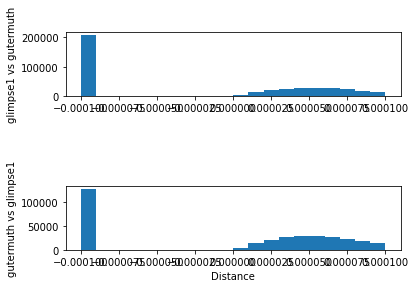

In [26]:
plt.figure(1)
plt.subplot(3,1,1)
plt.hist(glimpse1_dist, bins = 20)
plt.ylabel("glimpse1 vs gutermuth")

plt.subplot(3,1,3)
plt.hist(gutermuth_dist, bins = 20)
plt.xlabel("Distance")
plt.ylabel("gutermuth vs glimpse1")

plt.savefig('/home/kecai/w49/compare')
plt.show()